# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In this Project I used the dogs dataset to make classifications between the dog types.
Firstly I downloaded the data from the server to the S3.
Then I choosed some different hyperparameters to tune them.
I got the best hyper parameters then i fed them to a new estimator to make good results.
Also I made proffiles and debuggers for my model to check some statistical analysis and to check for errors.
after that I Deployed my model to an endpoint.
Lastly I deleted the endpoint to prevent getting over budget.

In [1]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [2]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import boto3
import sagemaker
from sagemaker.tensorflow import TensorFlow
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs, ProfilerConfig, FrameworkProfile

from smdebug.trials import create_trial

from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
from smdebug.core.modes import ModeKeys

from sagemaker.pytorch import PyTorch

from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts
import IPython





[2022-09-28 19:57:13.033 ip-172-16-146-210.ec2.internal:8254 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None


In [3]:
from PIL import Image
import io
from sagemaker.debugger import Rule, ProfilerRule, rule_configs
from IPython.display import Image as ImageDisplay
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

import numpy as np
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor
from sagemaker import get_execution_role
import os

Matplotlib is building the font cache; this may take a moment.


In [4]:
import sys

!{sys.executable} -m pip install "smdebug==1.0.3"
!{sys.executable} -m pip install "bokeh==2.3.0"

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     |████████████████████████████████| 262 kB 20.6 MB/s            
  Attempting uninstall: smdebug
    Found existing installation: smdebug 1.0.12
    Uninstalling smdebug-1.0.12:
      Successfully uninstalled smdebug-1.0.12
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     |████████████████████████████████| 10.6 MB 12.0 MB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for bokeh: filename=bokeh-2.3.0-py3-none-any.whl size=11292265 sha256=646fd4f4d13e6716b9df9eeea58b700afeff1fb8298929a4e10230ccd1d35388
  Stored in directory: /home/ec2-user/.cache/pip/wheels/28/7b/fe/a0ab08baf17336c920feb7c1d8e80fdd1c473d273ed0772b77
Successfully built bokeh
  Attempting uninstall: bokeh
    Found existing installation: bokeh 2.3.3
    Uninstalling bokeh-2.3.3:
      Successfully uninstalled bokeh-2.3.3


## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [5]:
#TODO: Fetch and upload the data to AWS S3
# I'm using the dogImages data set. It contains 133 types of dogs. I commented the downloading code because they are already downloaded before and I don't want to run the code again by mistake.
# Command to download and unzip data
#!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
#!unzip dogImages.zip

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [6]:
#I ill choose the learning rate , batch size and the epochs because they are mix of diccerent types ex.Catigorical/intiger/continious

In [7]:
session = sagemaker.Session()
bucket = session.default_bucket()  
region =session.boto_region_name
role = get_execution_role()
os.environ["DEFAULT_S3_BUCKET"] = bucket

In [8]:
# I deleted the rest of the data because I don't have enough budget to train the whole data, because it takes hours to train.

In [9]:
!aws s3 sync ./dogImages s3://${DEFAULT_S3_BUCKET}/dogImages/ --quiet

In [10]:
! aws s3 ls  s3://${DEFAULT_S3_BUCKET}/dogImages/test/

                           PRE 001.Affenpinscher/
                           PRE 002.Afghan_hound/


In [11]:
#TODO: Declare your HP ranges, metrics etc.
hyperparameter_ranges={
    "lr":ContinuousParameter(0.0001, 0.001),
    "batch_size":CategoricalParameter([32,64,128]),
    "epochs": IntegerParameter(3,6)
}

In [12]:
#TODO: Create estimators for your HPs

estimator = PyTorch(
    entry_point='hpo.py',
    py_version='py36',
    base_job_name='hpo_tuning',
    role=role,
    framework_version='1.8',
    instance_count=1,
    instance_type='ml.m5.large')

objective_metric_name = "average test accuracy"
objective_type = "Maximize"
metric_definitions = [{"Name": "average test accuracy", "Regex": "Testing Loss: ([0-9\\.]+)"}]

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=3,
    max_parallel_jobs=3,
    objective_type=objective_type)

train_data = "s3://{}/{}/".format(bucket, "dogImages")

In [13]:
# TODO: Fit your HP Tuner
tuner.fit({'train' : train_data},wait=True) # TODO: Remember to include your data channels


No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


.........................................................................!


In [14]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2022-09-28 20:02:47 Starting - Preparing the instances for training
2022-09-28 20:02:47 Downloading - Downloading input data
2022-09-28 20:02:47 Training - Training image download completed. Training in progress.
2022-09-28 20:02:47 Uploading - Uploading generated training model
2022-09-28 20:02:47 Completed - Resource retained for reuse


{'_tuning_objective_metric': '"average test accuracy"',
 'batch_size': '"128"',
 'epochs': '3',
 'lr': '0.0003685428692205665',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"hpo_tuning-2022-09-28-19-57-44-333"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-678985690247/hpo_tuning-2022-09-28-19-57-44-333/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [53]:
hyperparameters = {"batch_size": (best_estimator.hyperparameters()['batch_size']),
                   "lr": best_estimator.hyperparameters()['lr'],
                   "epochs": best_estimator.hyperparameters()['epochs']}

In [55]:
print(hyperparameters)

{'batch_size': '"128"', 'lr': '0.0003685428692205665', 'epochs': '3'}


In [67]:
hyperparameters = {"batch_size": "128", "epochs":"3", "lr": "0.0003685428692205665"}


In [68]:
# TODO: Set up debugging and profiling rules and hooks
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

collection_configs=[CollectionConfig(name="CrossEntropyLoss_output_0",parameters={
    "include_regex": "CrossEntropyLoss_output_0", "train.save_interval": "10","eval.save_interval": "1"})]

debugger_config=DebuggerHookConfig( collection_configs=collection_configs )

In [61]:
# TODO: Create and fit an estimator

estimator_second = PyTorch(
    role=role,
    instance_count=1,
    py_version="py36",
    instance_type="ml.m5.xlarge",
    debugger_hook_config=debugger_config,
    framework_version="1.8",
    hyperparameters=hyperparameters,
    entry_point="train_model.py",
    profiler_config=profiler_config,
    rules=rules
)

estimator_second.fit({'train' : train_data},wait=True) 

2022-09-28 20:48:23 Starting - Starting the training job...
2022-09-28 20:48:51 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
......
2022-09-28 20:49:52 Downloading - Downloading input data......
2022-09-28 20:50:52 Training - Downloading the training image...
2022-09-28 20:51:24 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-09-28 20:51:19,651 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-09-28 20:51:19,657 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-09-28 20:51:19,668 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-09-28 20:51:19,677 sagemaker_pytorch_container.training INF

In [62]:
trial = create_trial(estimator_second.latest_job_debugger_artifacts_path())

[2022-09-28 20:53:38.902 ip-172-16-146-210.ec2.internal:8254 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-678985690247/pytorch-training-2022-09-28-20-48-22-852/debug-output


In [63]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals


def ploting(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)

    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Train")
    par.set_xlabel("Evaluation")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)

    (p2,) = par.plot(steps_eval, vals_eval, label="validation_" + tensor_name)

    leg = plt.legend()


    plt.ylabel(tensor_name)

    plt.show()

[2022-09-28 20:53:39.308 ip-172-16-146-210.ec2.internal:8254 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-09-28 20:53:40.333 ip-172-16-146-210.ec2.internal:8254 INFO trial.py:210] Loaded all steps


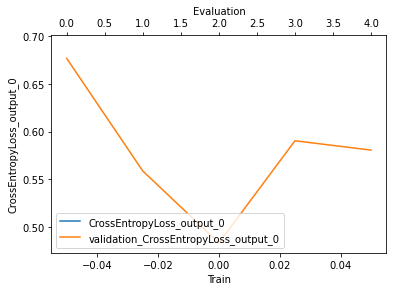

In [64]:
ploting(trial, "CrossEntropyLoss_output_0")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

Yes i couldn't import some pachages like "from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts"
and i got this error ImportError: cannot import name 'Markup' from 'jinja2' (/opt/conda/lib/python3.7/site-packages/jinja2/__init__.py)
Firstly I was using sagemaker studio but now I used the notebook instance and I didn't get the error anymore.

In [65]:
# TODO: Display the profiler output
profile_output = estimator_second.output_path + estimator_second.latest_training_job.job_name + "/rule-output"
! aws s3 ls {profile_output} --recursive
! aws s3 cp {profile_output} ./ --recursive

profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator_second.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")


2022-09-28 20:53:38     365215 pytorch-training-2022-09-28-20-48-22-852/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-09-28 20:53:38     212280 pytorch-training-2022-09-28-20-48-22-852/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-09-28 20:53:40        191 pytorch-training-2022-09-28-20-48-22-852/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-09-28 20:53:40        199 pytorch-training-2022-09-28-20-48-22-852/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-09-28 20:53:40       1996 pytorch-training-2022-09-28-20-48-22-852/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-09-28 20:53:40        127 pytorch-training-2022-09-28-20-48-22-852/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-09-28 20:53:40        198 pytorch-training-2022-09-28-20-48-22-852/rule-output/ProfilerReport/profiler-output/profiler-re

## Model Deploying

In [42]:
model_artifact=estimator_second.model_data

jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

In [43]:
# TODO: Deploy your model to an endpoint


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [69]:
# TODO: Add your deployment configuration like instance type and number of instances
pytorch_model = PyTorchModel(model_data=model_artifact, role=role, entry_point='endpoint_inference.py',py_version='py36',
                             framework_version='1.8',
                             predictor_cls=ImagePredictor) 

predictor=pytorch_model.deploy(initial_instance_count=1, instance_type="ml.m5.large") 

------!

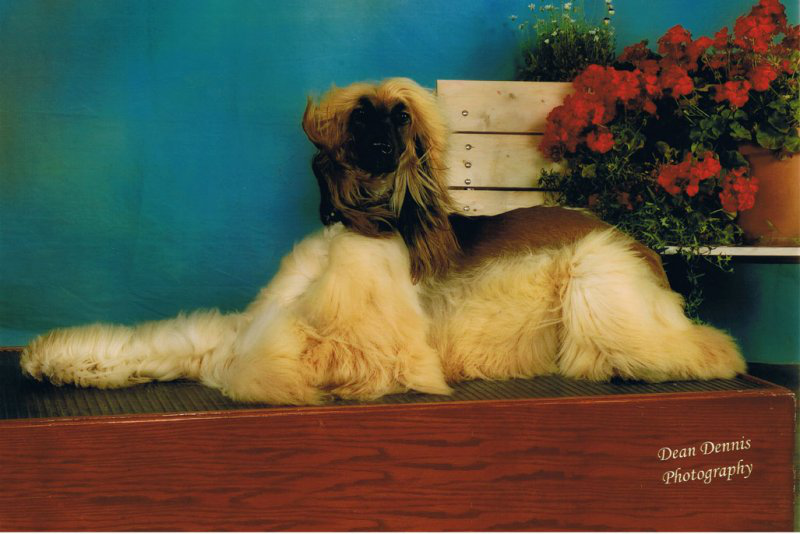

In [70]:
with open("./dogImages/test/002.Afghan_hound/Afghan_hound_00141.jpg", "rb") as f: 
    image = f.read()
Image.open(io.BytesIO(image))


In [71]:
# TODO: Run an prediction on the endpoint
test1 = io.BytesIO()
Image.open("./dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg").save(test1, format="JPEG")


In [72]:
response = predictor.predict(test1.getvalue())

In [78]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()

In [ ]:
#import shutil
'''
#shutil.rmtree('dogImages/test/001.Affenpinscher', ignore_errors=True)
#shutil.rmtree('dogImages/test/002.Afghan_hound', ignore_errors=True)
#shutil.rmtree('dogImages/test/003.Airedale_terrier', ignore_errors=True)
#shutil.rmtree('dogImages/test/004.Akita', ignore_errors=True)
#shutil.rmtree('dogImages/test/005.Alaskan_malamute', ignore_errors=True)
#shutil.rmtree('dogImages/test/006.American_eskimo_dog', ignore_errors=True)
#shutil.rmtree('dogImages/test/007.American_foxhound', ignore_errors=True)
#shutil.rmtree('dogImages/test/008.American_staffordshire_terrier', ignore_errors=True)
#shutil.rmtree('dogImages/test/009.American_water_spaniel', ignore_errors=True)
#shutil.rmtree('dogImages/test/010.Anatolian_shepherd_dog', ignore_errors=True)
#shutil.rmtree('dogImages/test/011.Australian_cattle_dog', ignore_errors=True)
#shutil.rmtree('dogImages/test/012.Australian_shepherd', ignore_errors=True)
#shutil.rmtree('dogImages/test/013.Australian_terrier', ignore_errors=True)
'''

In [ ]:
#shutil.rmtree('dogImages/test', ignore_errors=True)
#shutil.rmtree('dogImages/train', ignore_errors=True)
#shutil.rmtree('dogImages/valid', ignore_errors=True)